In [1]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, diffpair_cc, current_mirror_cc, spice_sim, cm_pmos
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import paretoset as pareto

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

In [ ]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

lut_file = "../../LUTs/gf_LUT_03v3.npy"
lut_w = 20e-6

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                    # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp2 = 25e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,1.200000e+00
Vin,1.800000e+00
Vref,9.000000e-01
IL,5.000000e-03
CL,5.000000e-13
RL,2.400000e+02
Iq_max,1.000000e-04
Ib_pt,6.500000e-05
R1,4.615385e+03
R2,1.384615e+04


In [44]:
Vota = 0.688

In [45]:
## LDO MACROMODEL

LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

## OTA CASCODE DIFFPAIR MACROMODEL

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')
    ],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

In [46]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*3.3)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

In [47]:
gain_OTA = Test()
gain_OTA.tf = ("vout", "vpos")
gain_OTA.name = "gain_OTA"
gain_OTA.netlist = "ota_1stage"
gain_OTA.parametros = {
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("gdiff_2"): Symbol("gdiff_1"), 
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("V1"): 0,
    Symbol("V_b"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0,
    Symbol("Cl"): 1e-1}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "ota_1stage_rout"
rout_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "ota_1stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

In [48]:
pt = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): pt_df['cgd'].values,
    Symbol("Cin_pt"): pt_df['cgg'].values+pt_df["cgd"].values*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"].values/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        +pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        *pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.73553927 -0.74399375 -0.73784767 -0.73420468 -0.73229168]
length
vgs
0


In [49]:
pt_df

,length,width,gdsid,gds,Ro,cgg,gm,cgs,cgd
0,4.000000e-07,0.000902,0.111553,0.000565,1769.862700,1.194408e-12,0.026541,-9.640803e-13,-2.246911e-15
1,8.000000e-07,0.002196,0.047427,0.000240,4162.886967,5.739343e-12,0.028081,-4.782494e-12,-1.775390e-14
2,1.600000e-06,0.004668,0.025238,0.000128,7822.880201,2.412505e-11,0.027696,-2.026255e-11,-5.963904e-14
3,3.200000e-06,0.009676,0.014447,0.000073,13665.618330,9.861256e-11,0.027419,-8.289429e-11,-1.723148e-13


In [ ]:
sweep_size_dp = 5
vin_dp = OTA_macro.electrical_parameters["Vref"]
vout_dp = OTA_macro.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_dp, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    lut_file,
    lut_w)

diffpair_primitive_df =  diffpair_primitive.build()

diffpair_primitive_mask = (diffpair_primitive_df["width_m1"]>1e-6) & (diffpair_primitive_df["width_m2"]>2e-6) & (diffpair_primitive_df["width_m1"]<4e-6) & (diffpair_primitive_df["width_m2"]<1e-4)

diffpair_primitive_df = diffpair_primitive_df[diffpair_primitive_mask]

diffpair_primitive.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df["Ro"].values, 
                                 Symbol("gdiff_1"): diffpair_primitive_df["gm"].values,
                                 Symbol("vbias"): diffpair_primitive_df["vbias"].values,
                                 Symbol("vs_diff"): diffpair_primitive_df["vs"].values}

diffpair_primitive.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

vout_cm = 0.688 - Vin
sweep_size_cm = 5

vcp_cm = np.linspace(vout_cm+0.1, -0.1, sweep_size_cm)

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive = current_mirror_cc(
    vcp_cm, 
    vout_cm, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    lut_file,
    lut_w)

activeload_primitive_df = activeload_primmitive.build()

activeload_primitive_mask = (activeload_primitive_df["width_m1"]>1e-6) & (activeload_primitive_df["width_m2"]>5e-6) & (activeload_primitive_df["width_m1"]<1e-4) & (activeload_primitive_df["width_m2"]<1e-4)
activeload_primitive_df = activeload_primitive_df[activeload_primitive_mask]

activeload_primmitive.parameters = {Symbol("Raload_1"): activeload_primitive_df["Ro"].values,
                                    Symbol("gaload_1"): activeload_primitive_df["gm"].values,
                                    Symbol("vbias_cm"): activeload_primitive_df["vbias"].values}
activeload_primmitive.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}
                                 

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}

for vds_cs in vs_dp:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp2,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

mask = (currentsource.outputs[Symbol('W_cs')]<3e-4) & (currentsource.outputs[Symbol('W_cs')]>1e-6)

currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()[mask]
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()[mask]
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()[mask]
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()[mask]
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()[mask]
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()[mask]
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

vds
vgs
1
M1 jd:  [[3.99425947e+00 2.31289643e-01 3.09608127e-03 2.45039513e-05
  1.76873920e-07 3.95277800e+00 2.26741833e-01 3.01750044e-03
  2.36957920e-05            nan 3.91025099e+00 2.21935142e-01
  2.93284323e-03 2.25825767e-05            nan 3.86553825e+00
  2.17193154e-01 2.84405137e-03            nan            nan
  3.81803010e+00 2.12226604e-01 2.72912923e-03            nan
             nan]
 [1.84616068e+00 9.41745849e-02 1.22275138e-03 1.00301722e-05
  8.01316842e-08 1.83979580e+00 9.35324894e-02 1.21215301e-03
  9.90442011e-06            nan 1.83328858e+00 9.27829232e-02
  1.19958250e-03 9.71900657e-06            nan 1.82622820e+00
  9.20887879e-02 1.18677037e-03            nan            nan
  1.81860579e+00 9.13506147e-02 1.16860448e-03            nan
             nan]
 [1.05155676e+00 6.32473932e-02 8.99558837e-04 7.59023396e-06
  6.30052265e-08 1.04938174e+00 6.29819311e-02 8.94562860e-04
  7.52779840e-06            nan 1.04719922e+00 6.26557756e-02
  8.88403132e-04

In [70]:
diffpair_primitive_df

,width_m1,length_m1,width_m2,length_m2,gds,Ro,gm,cout,ccp,vbias,vs


In [51]:
vout_2stage_wc = 1.05

In [52]:
diffpair_primitive_wc = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_2stage_wc, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    lut_file,
    lut_w)

diffpair_primitive_df_wc =  diffpair_primitive_wc.build()

diffpair_primitive_wc.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df_wc["Ro"].values[diffpair_primitive_mask], 
                                 Symbol("gdiff_1"): diffpair_primitive_df_wc["gm"].values[diffpair_primitive_mask],
                                 Symbol("vbias"): diffpair_primitive_df_wc["vbias"].values[diffpair_primitive_mask],
                                 Symbol("vs_diff"): diffpair_primitive_df_wc["vs"].values[diffpair_primitive_mask]}
diffpair_primitive_wc.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive_wc = current_mirror_cc(
    vcp_cm, 
    vout_2stage_wc-1.8, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    lut_file,
    lut_w)

activeload_primitive_df_wc = activeload_primmitive_wc.build()

activeload_primmitive_wc.parameters = {Symbol("Raload_1"): activeload_primitive_df_wc["Ro"].values[activeload_primitive_mask],
                                    Symbol("gaload_1"): activeload_primitive_df_wc["gm"].values[activeload_primitive_mask],
                                    Symbol("vbias_cm"): activeload_primitive_df_wc["vbias"].values[activeload_primitive_mask]}

activeload_primmitive_wc.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}

vds
vgs
1
M1 jd:  [[3.99425947e+00 2.31289643e-01 3.09608127e-03 2.45039513e-05
  1.76873920e-07 3.95277800e+00 2.26741833e-01 3.01750044e-03
  2.36957920e-05            nan 3.91025099e+00 2.21935142e-01
  2.93284323e-03 2.25825767e-05            nan 3.86553825e+00
  2.17193154e-01 2.84405137e-03            nan            nan
  3.81803010e+00 2.12226604e-01 2.72912923e-03            nan
             nan]
 [1.84616068e+00 9.41745849e-02 1.22275138e-03 1.00301722e-05
  8.01316842e-08 1.83979580e+00 9.35324894e-02 1.21215301e-03
  9.90442011e-06            nan 1.83328858e+00 9.27829232e-02
  1.19958250e-03 9.71900657e-06            nan 1.82622820e+00
  9.20887879e-02 1.18677037e-03            nan            nan
  1.81860579e+00 9.13506147e-02 1.16860448e-03            nan
             nan]
 [1.05155676e+00 6.32473932e-02 8.99558837e-04 7.59023396e-06
  6.30052265e-08 1.04938174e+00 6.29819311e-02 8.94562860e-04
  7.52779840e-06            nan 1.04719922e+00 6.26557756e-02
  8.88403132e-04

In [53]:
diffpair_primitive_df

,width_m1,length_m1,width_m2,length_m2,gds,Ro,gm,cout,ccp,vbias,vs


In [54]:
gain = []
area = []
for i in activeload_primitive_df["Ro"].values:
    gain.append(20*np.log10((diffpair_primitive.parameters[Symbol("gdiff_1")])*(diffpair_primitive.parameters[Symbol("Rdiff_1")])*i/((diffpair_primitive.parameters[Symbol("Rdiff_1")])+i)))
    area.append(diffpair_primitive.outputs[Symbol("W_diff_m1")])

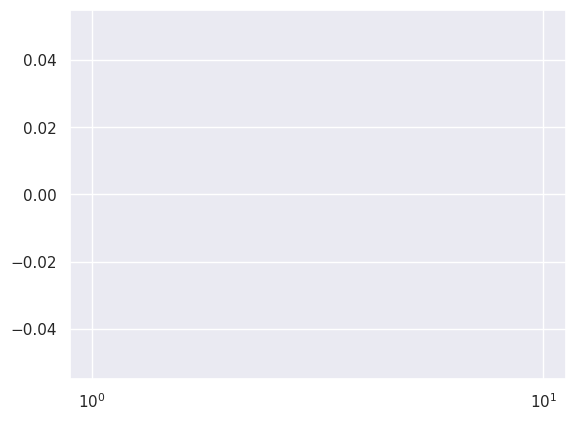

In [55]:
plt.scatter(area, gain)
plt.xscale("log")

In [56]:
len(diffpair_primitive_df)*len(activeload_primitive_df)*len(currentsource.parameters[Symbol("gcs")])

0

In [57]:
currentsource.outputs[Symbol("W_cs")]

array([3.78678895e-05, 7.71638176e-05, 1.19077886e-04, 1.98823446e-04,
       5.24813456e-05, 4.03050138e-06, 1.16534489e-04, 7.90383438e-06,
       1.78891789e-04, 1.42364132e-05, 2.92678824e-04, 2.71833153e-05,
       5.32954479e-05, 8.10449185e-05, 4.77396149e-06, 1.33712237e-06,
       1.89591886e-04, 9.72901260e-06, 2.52055320e-06, 2.86254818e-04,
       1.74805538e-05, 4.71755427e-06, 3.32025977e-05, 9.30146380e-06,
       6.49536258e-05, 1.85372916e-05, 1.29928014e-04, 5.90945552e-06,
       1.46284854e-06, 1.23969325e-05, 2.82383631e-06, 1.25411615e-06,
       2.20529953e-05, 5.30786426e-06, 2.34424341e-06, 4.14842719e-05,
       1.04747936e-05, 4.63995024e-06, 8.08007356e-05, 2.08866617e-05,
       9.27350131e-06, 2.13511270e-04, 7.51077897e-06, 1.62992399e-06,
       1.62499399e-05, 3.20995522e-06, 1.34937869e-06, 2.85291305e-05,
       6.03916948e-06, 2.53741565e-06, 1.41796814e-06, 5.30084762e-05,
       1.19073636e-05, 5.03520237e-06, 2.79282462e-06, 1.02666506e-04,
      

In [58]:
OTA_macro.ext_mask = None

OTA_macro.primitives = [diffpair_primitive_wc, activeload_primmitive_wc, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, ota_df_wc_mask = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OTA_macro
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0


[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 + 2*Raload_1**2*Rcs*gaload_1 + Raload_1**2*Rdiff_1*gaload_1 + Raload_1**2 + 2*Raload_1*Rcs*Rdiff_1**2*gaload_1*gdiff_1 + 2*Raload_1*Rcs*Rdiff_1*gaload_1 + 2*Raload_1*Rcs*Rdiff_1*gdiff_1 + 2*Raload_1*Rcs + Raload_1*Rdiff_1**2*gaload_1 + 2*Raload_1*Rdiff_1 + 2*Rcs*Rdiff_1**2*gdiff_1 + 2*Rcs*Rdiff_1 + Rdiff_1**2)
lambdi

In [59]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
len(ota_df_wc)

0

<Axes: >

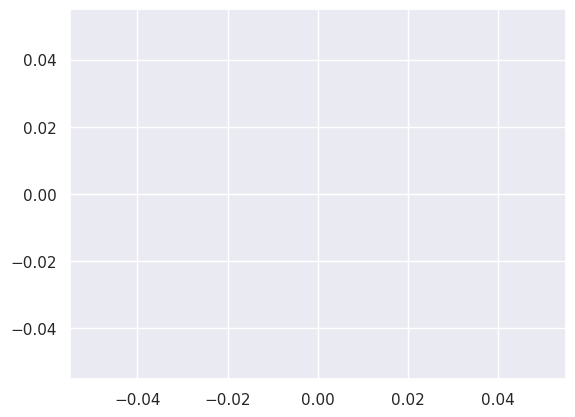

In [60]:
sns.scatterplot(data=ota_df_wc, x="area", y="gain")

In [61]:
OTA_macro.ext_mask = ota_df_wc_mask

OTA_macro.primitives = [diffpair_primitive, activeload_primmitive, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_1stage
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0


[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 + 2*Raload_1**2*Rcs*gaload_1 + Raload_1**2*Rdiff_1*gaload_1 + Raload_1**2 + 2*Raload_1*Rcs*Rdiff_1**2*gaload_1*gdiff_1 + 2*Raload_1*Rcs*Rdiff_1*gaload_1 + 2*Raload_1*Rcs*Rdiff_1*gdiff_1 + 2*Raload_1*Rcs + Raload_1*Rdiff_1**2*gaload_1 + 2*Raload_1*Rdiff_1 + 2*Rcs*Rdiff_1**2*gdiff_1 + 2*Rcs*Rdiff_1 + Rdiff_1**2)
lambdi

In [62]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
len(ota_df)

0

<Axes: >

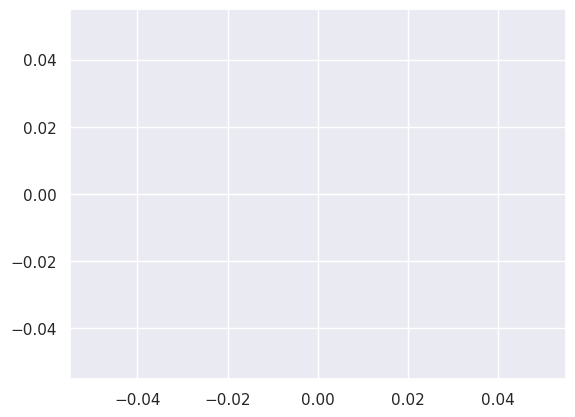

In [63]:
sns.scatterplot(data=ota_df, x="area", y="gain")

In [40]:
Cin_pt = 4.86e-12
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["bw"] = 1/(2*np.pi*ota_df["rout_OTA"]*Cin_pt)

mask = ota_df["gain"]>10
ota_df = ota_df[mask]

ota_df_new = ota_df
ota_df_new.sort_values(by="gain")

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area,gain,gain_wc,bw
60,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000295,60789.088100,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000244,6.400000e-06,0.000383,45.216479,60.350881,19957.472926
59,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000306,53190.042779,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000133,3.200000e-06,0.000269,45.217061,60.350898,19957.738152
58,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000328,43886.524328,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000079,1.600000e-06,0.000214,45.218022,60.350925,19958.176380
57,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000348,33476.298208,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000051,8.000000e-07,0.000185,45.219655,60.350973,19958.921516
56,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000330,20459.025970,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000025,4.000000e-07,0.000159,45.223616,60.351087,19960.729031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,9.828165e+06,0.000112,1.188,0.1,5.600978e+09,0.000054,-1.612,0.000295,60789.088100,0.1,...,0.000039,6.400000e-06,0.000054,6.400000e-06,0.000244,6.400000e-06,0.000451,60.820823,68.258829,3334.975989
4763,9.828165e+06,0.000112,1.188,0.1,5.600978e+09,0.000054,-1.612,0.000306,53190.042779,0.1,...,0.000039,6.400000e-06,0.000054,6.400000e-06,0.000133,3.200000e-06,0.000337,60.820823,68.258834,3335.004250
4762,9.828165e+06,0.000112,1.188,0.1,5.600978e+09,0.000054,-1.612,0.000328,43886.524328,0.1,...,0.000039,6.400000e-06,0.000054,6.400000e-06,0.000079,1.600000e-06,0.000282,60.820823,68.258841,3335.050944
4761,9.828165e+06,0.000112,1.188,0.1,5.600978e+09,0.000054,-1.612,0.000348,33476.298208,0.1,...,0.000039,6.400000e-06,0.000054,6.400000e-06,0.000051,8.000000e-07,0.000253,60.820824,68.258853,3335.130343


In [41]:
ota_df_wc_new = ota_df_wc[mask]
ota_df_wc_new

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area,gain
0,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000330,20459.025970,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000025,4.000000e-07,0.000153,67.194663
1,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000348,33476.298208,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000051,8.000000e-07,0.000179,67.194626
2,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000328,43886.524328,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000079,1.600000e-06,0.000208,67.194611
3,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000306,53190.042779,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000133,3.200000e-06,0.000263,67.194602
4,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000295,60789.088100,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000244,6.400000e-06,0.000377,67.194597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,4.682790e+07,0.000112,1.188,0.1,8.555935e+06,0.000198,-1.612,0.000330,20459.025970,0.1,...,4.000000e-07,4.000000e-07,0.000066,6.400000e-06,0.000009,6.400000e-06,0.000025,4.000000e-07,0.000208,58.172290
4985,4.682790e+07,0.000112,1.188,0.1,8.555935e+06,0.000198,-1.612,0.000348,33476.298208,0.1,...,4.000000e-07,4.000000e-07,0.000066,6.400000e-06,0.000009,6.400000e-06,0.000051,8.000000e-07,0.000234,58.172132
4986,4.682790e+07,0.000112,1.188,0.1,8.555935e+06,0.000198,-1.612,0.000328,43886.524328,0.1,...,4.000000e-07,4.000000e-07,0.000066,6.400000e-06,0.000009,6.400000e-06,0.000079,1.600000e-06,0.000263,58.172067
4987,4.682790e+07,0.000112,1.188,0.1,8.555935e+06,0.000198,-1.612,0.000306,53190.042779,0.1,...,4.000000e-07,4.000000e-07,0.000066,6.400000e-06,0.000009,6.400000e-06,0.000133,3.200000e-06,0.000318,58.172029


/tmp/ipykernel_55945/4192085568.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc = 'upper right')
/tmp/ipykernel_55945/4192085568.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')
/tmp/ipykernel_55945/4192085568.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc = 'upper right')


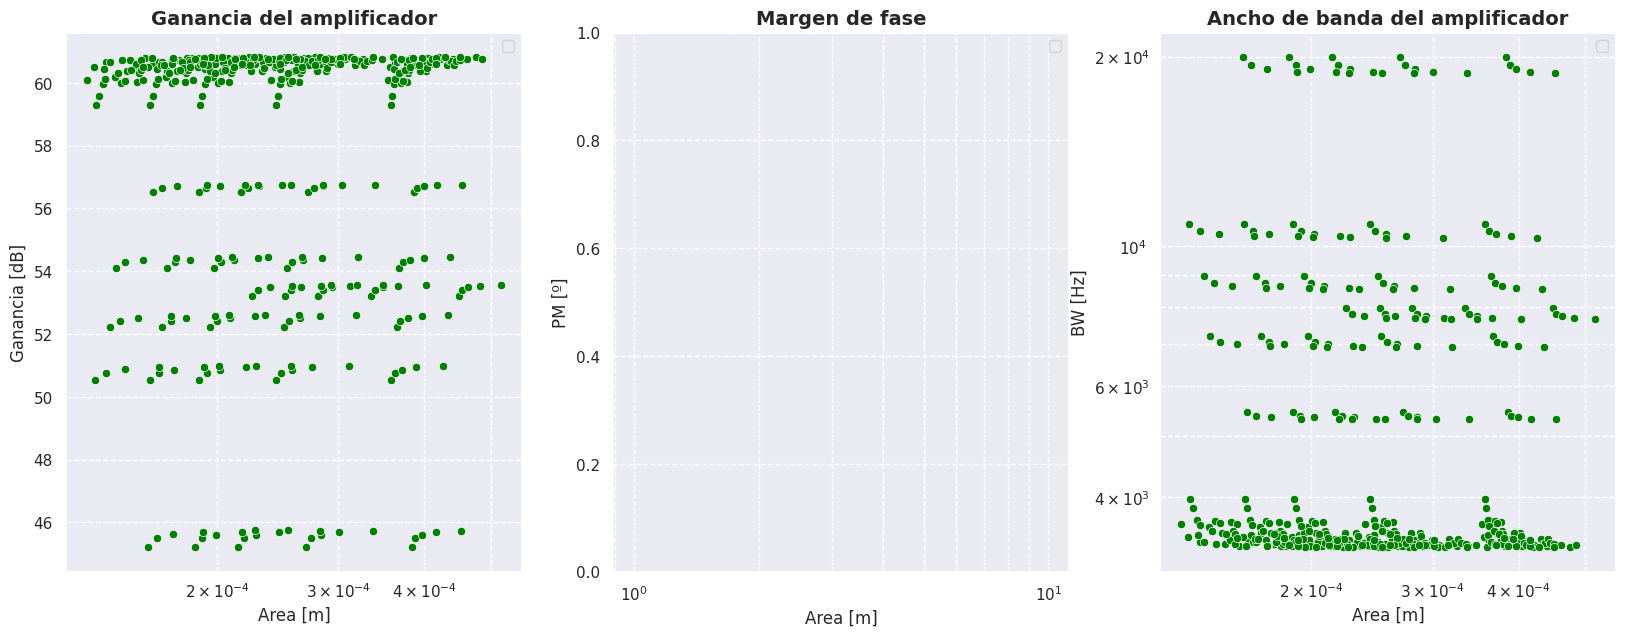

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
#sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare')
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
#sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
#sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
#sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('fullcc_ota_explore_raw_SKY.pdf')